# Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MTS ML Cup

/content/drive/MyDrive/MTS ML Cup


In [ ]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/MTS ML Cup/src')

In [ ]:
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore');

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import bisect

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import sklearn.metrics as m
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from metric_functions import get_metrics_classification, get_metrics_multiclass, check_overfitting_classification, check_overfitting_multiclass

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
RAND = 42

final_types = {
    'user_id': 'int32',
    'part_of_day_day': 'int16',
    'part_of_day_night': 'int16',
    'day_pct': 'float32',
    'evening_pct': 'float32',
    'morning_pct': 'float32',
    'night_pct': 'float32',
    'act_days': 'int16',
    'avg_req_per_day': 'float32',
    'requests_std': 'float32',
    'act_days_pct': 'float32',
    'cpe_type_cd': 'category',
    'cpe_model_os_type': 'category',
    'cpe_manufacturer_name': 'category',
    'price': 'float32',
    'region_cnt': 'int8',
    'city_cnt': 'int8',
    'url_host_cnt': 'int16',
}

# Сбор всех данных

In [ ]:
id_to_submit = pd.read_parquet('submit.pqt')

In [ ]:
targets = pd.read_parquet('public_train.pqt')

In [ ]:
df = pd.read_csv('data_agg/df_final.csv')

In [ ]:
df = df.astype(final_types)

In [ ]:
df.head()

,user_id,part_of_day_day,part_of_day_night,day_pct,evening_pct,morning_pct,night_pct,act_days,avg_req_per_day,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,4,199,10,0.336717,0.287648,0.358714,0.016920,20,38.849998,0.647632,0.4650,smartphone,Android,Huawei,12990.0,5,9,108
1,16,443,137,0.359870,0.260764,0.268075,0.111292,64,39.515625,1.397836,0.8647,smartphone,Android,Samsung,9583.0,1,1,50
2,18,566,34,0.503111,0.101333,0.365333,0.030222,32,60.937500,1.204972,0.8423,smartphone,Android,Samsung,22887.0,1,2,141
3,26,180,126,0.176817,0.400786,0.298625,0.123772,20,71.800003,0.688696,0.9090,smartphone,Android,Samsung,4990.0,1,1,126
4,27,808,342,0.302622,0.331461,0.237828,0.128090,67,66.074623,1.088583,0.9307,smartphone,Android,Xiaomi,12990.0,1,2,209


In [ ]:
df_train = targets.merge(df, how='inner', on=['user_id'])

df_train

,age,is_male,user_id,part_of_day_day,part_of_day_night,day_pct,evening_pct,morning_pct,night_pct,act_days,avg_req_per_day,requests_std,act_days_pct,cpe_type_cd,cpe_model_os_type,cpe_manufacturer_name,price,region_cnt,city_cnt,url_host_cnt
0,31.0,1,350459,84,0,0.471910,0.151685,0.376404,0.000000,28,8.571428,0.745626,0.8750,smartphone,Android,Xiaomi,14948.0,1,1,36
1,35.0,1,188276,33,10,0.297297,0.369369,0.243243,0.090090,14,11.214286,0.719450,0.8237,smartphone,Android,Samsung,11434.0,1,1,21
2,41.0,0,99002,310,15,0.485133,0.309859,0.181534,0.023474,48,17.833334,0.729268,0.9060,smartphone,Android,Huawei,18288.0,1,3,121
3,33.0,0,155506,6,0,0.272727,0.000000,0.727273,0.000000,2,19.000000,1.162174,1.0000,smartphone,iOS,Apple,37090.0,1,1,19
4,54.0,0,213873,0,0,0.000000,0.000000,1.000000,0.000000,1,4.000000,0.000000,1.0000,smartphone,Android,Huawei,8987.0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269995,49.0,1,225374,554,66,0.335148,0.300665,0.324259,0.039927,37,71.540543,1.157740,0.9250,smartphone,Android,Samsung,12990.0,4,6,209
269996,22.0,1,25776,26,36,0.216667,0.425000,0.058333,0.300000,21,7.238095,0.530314,0.8076,smartphone,Android,Xiaomi,-999.0,1,1,32
269997,28.0,0,148131,71,34,0.349754,0.275862,0.206897,0.167488,19,15.473684,0.796673,1.0000,smartphone,iOS,Apple,57202.0,2,4,31
269998,28.0,1,205570,215,51,0.429142,0.231537,0.237525,0.101796,32,26.593750,1.107690,0.4775,smartphone,Android,Huawei,14154.0,9,15,60


# Baseline gender prediction

In [ ]:
df_train = targets.merge(df, how='inner', on=['user_id'])

df_train = df_train[df_train['is_male'] != 'NA']
df_train = df_train.dropna()
df_train['is_male'] = df_train['is_male'].map(int)
df_train['is_male'].value_counts()

1    135331
0    128994
Name: is_male, dtype: int64

In [ ]:
%%time
X = df_train.drop(['user_id', 'age', 'is_male'], axis=1)
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 126 ms, sys: 5.52 ms, total: 131 ms
Wall time: 130 ms


## LGBM

In [ ]:
%%time
lgbm_gender = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

lgbm_gender.fit(X_train_,
                y_train_,
                eval_metric='auc',
                eval_set=eval_set,
                early_stopping_rounds=100,
                verbose=False)

CPU times: user 5.01 s, sys: 7.67 ms, total: 5.02 s
Wall time: 1.35 s


LGBMClassifier(random_state=42, scale_pos_weight=0.9531740695036613)

In [ ]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, lgbm_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.257


In [ ]:
check_overfitting_classification(lgbm_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.652
ROC-AUC test = 0.629
delta = 3.67%


In [ ]:
y_pred_test = lgbm_gender.predict(X_test)
y_score_test = lgbm_gender.predict_proba(X_test)

metrics_gender = get_metrics_classification(y_test,
                                            y_pred_test,
                                            y_score_test,
                                            name='LGBMBaseline')
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.58562,0.628592,0.257185


## CatBoost

In [ ]:
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_gender = CatBoostClassifier(allow_writing_files=False,
                                random_state=RAND,
                                eval_metric="AUC",
                                cat_features=cat_features,
                                scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

cat_gender.fit(X_train_,
               y_train_,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

CPU times: user 1min 31s, sys: 2.78 s, total: 1min 34s
Wall time: 28.1 s


In [ ]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, cat_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.260


In [ ]:
check_overfitting_classification(cat_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.653
ROC-AUC test = 0.630
delta = 3.57%


In [ ]:
y_pred_test = cat_gender.predict(X_test)
y_score_test = cat_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='CatBoostBaseline'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
0,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068


## XGBoost

In [ ]:
%%time
X = pd.get_dummies(df_train.drop(['user_id', 'age', 'is_male'], axis=1))
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

# значение для scale_pos_weight
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

CPU times: user 264 ms, sys: 3.89 ms, total: 268 ms
Wall time: 267 ms


In [ ]:
%%time
xgb_gender = XGBClassifier(random_state=RAND, scale_pos_weight=ratio)
eval_set = [(X_val, y_val)]

xgb_gender.fit(X_train_,
               y_train_,
               eval_metric='auc',
               eval_set=eval_set,
               early_stopping_rounds=100,
               verbose=0)

CPU times: user 1min 21s, sys: 84.5 ms, total: 1min 21s
Wall time: 21.9 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [ ]:
print(
    f'GINI по полу {2 * m.roc_auc_score(y_test, xgb_gender.predict_proba(X_test)[:,1]) - 1:2.3f}'
)

GINI по полу 0.247


In [ ]:
check_overfitting_classification(xgb_gender, X_train, y_train, X_test, y_test)

ROC-AUC train = 0.678
ROC-AUC test = 0.623
delta = 8.81%


In [ ]:
y_pred_test = xgb_gender.predict(X_test)
y_score_test = xgb_gender.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='XGBoostBaseline'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
0,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
0,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683


## RandomForest

In [ ]:
%%time
X = pd.get_dummies(df_train.drop(['user_id', 'age', 'is_male'], axis=1))
y = df_train['is_male']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

CPU times: user 250 ms, sys: 26.2 ms, total: 276 ms
Wall time: 275 ms


In [ ]:
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=RAND)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
y_pred_test = clf_rf.predict(X_test)
y_score_test = clf_rf.predict_proba(X_test)

metrics_gender = metrics_gender.append(
    get_metrics_classification(y_test,
                               y_pred_test,
                               y_score_test,
                               name='RandomForestBaseline'))
metrics_gender

,model,Precision,Recall,f1,ROC_AUC,GINI
0,LGBMBaseline,0.607814,0.564989,0.585620,0.628592,0.257185
0,CatBoostBaseline,0.611604,0.565913,0.587872,0.630034,0.260068
0,XGBoostBaseline,0.606800,0.555863,0.580216,0.623342,0.246683
0,RandomForestBaseline,0.584381,0.585569,0.584974,0.600485,0.200970


Вывод: лучше всего себя показал бейзлайн catboost

In [ ]:
metrics_gender.to_csv('./metrics/metrics_gender_baseline.csv', index=False)

# Baseline age prediction

In [ ]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

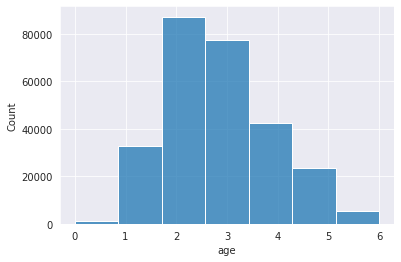

In [ ]:
df_trn = targets.merge(df, how='inner', on=['user_id'])

df_trn = df_trn[df_trn['age'] != 'NA']
df_trn = df_trn.dropna()
df_trn['age'] = df_trn['age'].map(age_bucket)
sns.histplot(df_trn['age'], bins=7)

In [ ]:
# разбивка данных на train и test
X = df_trn.drop(['age', 'is_male', 'user_id'], axis=1)
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

n_classes = len(set(y))
y_train_bin = label_binarize(y_train, classes=list(set(y)))
y_test_bin = label_binarize(y_test, classes=list(set(y)))

## LGBM

In [ ]:
%%time
lgbm_age = LGBMClassifier(random_state=RAND,
                          class_weight='balanced',
                          objective='multiclass')
eval_set = [(X_val, y_val)]

lgbm_age.fit(X_train_,
             y_train_,
             eval_set=eval_set,
             early_stopping_rounds=100,
             verbose=False)

CPU times: user 25.1 s, sys: 148 ms, total: 25.2 s
Wall time: 6.6 s


LGBMClassifier(class_weight='balanced', objective='multiclass', random_state=42)

In [ ]:
check_overfitting_multiclass(lgbm_age, X_train, y_train_bin, X_test,
                             y_test_bin)

ROC-AUC train = 0.749
ROC-AUC test = 0.665
delta = 12.49%


In [ ]:
print(
    m.classification_report(y_test,
                            lgbm_age.predict(X_test),
                            target_names=[
                                '<18', '18-25', '25-34', '35-44', '45-54',
                                '55-65', '65+'
                            ]))

              precision    recall  f1-score   support

         <18       0.01      0.18      0.02       207
       18-25       0.26      0.45      0.33      6528
       25-34       0.41      0.20      0.26     17454
       35-44       0.35      0.17      0.23     15497
       45-54       0.22      0.17      0.19      8489
       55-65       0.15      0.23      0.19      4716
         65+       0.05      0.40      0.09      1101

    accuracy                           0.22     53992
   macro avg       0.21      0.26      0.19     53992
weighted avg       0.31      0.22      0.24     53992



In [ ]:
y_pred = lgbm_age.predict(X_test)
y_score = lgbm_age.predict_proba(X_test)

metrics_age = get_metrics_multiclass(y_test_bin=y_test_bin,
                                     y_test=y_test,
                                     y_pred=y_pred,
                                     y_prob=y_score,
                                     name='LGBM_Baseline',
                                     type_multi='ovo')
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.66544,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957


## Catboost

In [ ]:
%%time
cat_features = X.select_dtypes('category').columns.tolist()
cat_age = CatBoostClassifier(allow_writing_files=False,
                             cat_features=cat_features,
                             random_state=RAND)
eval_set = [(X_val, y_val)]

cat_age.fit(X_train,
            y_train,
            eval_set=eval_set,
            early_stopping_rounds=100,
            verbose=False)

CPU times: user 37min 21s, sys: 32 s, total: 37min 53s
Wall time: 10min 27s


In [ ]:
check_overfitting_multiclass(cat_age, X_train, y_train_bin, X_test, y_test_bin)

ROC-AUC train = 0.766
ROC-AUC test = 0.679
delta = 12.88%


In [ ]:
print(
    m.classification_report(y_test,
                            cat_age.predict(X_test),
                            target_names=[
                                '<18', '18-25', '25-34', '35-44', '45-54',
                                '55-65', '65+'
                            ]))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       207
       18-25       0.41      0.12      0.19      6528
       25-34       0.39      0.60      0.48     17454
       35-44       0.33      0.48      0.39     15497
       45-54       0.30      0.09      0.13      8489
       55-65       0.29      0.05      0.09      4716
         65+       0.10      0.00      0.00      1101

    accuracy                           0.36     53992
   macro avg       0.26      0.19      0.18     53992
weighted avg       0.35      0.36      0.32     53992



In [ ]:
y_pred = cat_age.predict(X_test)
y_score = cat_age.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='CatBoost_Baseline',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.665440,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957
0,CatBoost_Baseline,0.678626,0.363721,0.260785,0.363721,0.191032,0.363721,0.182633,1.483299


## RandomForest

In [ ]:
%%time
X = pd.get_dummies(df_trn.drop(['age', 'is_male', 'user_id'], axis=1))
y = df_trn['age']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=RAND)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

CPU times: user 251 ms, sys: 24 ms, total: 275 ms
Wall time: 275 ms


In [ ]:
clf_rf = RandomForestClassifier(class_weight='balanced', random_state=RAND)

clf_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
print(
    m.classification_report(y_test,
                            clf_rf.predict(X_test),
                            target_names=[
                                '<18', '18-25', '25-34', '35-44', '45-54',
                                '55-65', '65+'
                            ]))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       207
       18-25       0.37      0.12      0.18      6528
       25-34       0.37      0.60      0.46     17454
       35-44       0.33      0.43      0.37     15497
       45-54       0.24      0.08      0.12      8489
       55-65       0.22      0.04      0.06      4716
         65+       0.00      0.00      0.00      1101

    accuracy                           0.35     53992
   macro avg       0.22      0.18      0.17     53992
weighted avg       0.32      0.35      0.30     53992



In [ ]:
y_pred = clf_rf.predict(X_test)
y_score = clf_rf.predict_proba(X_test)

metrics_age = metrics_age.append(
    get_metrics_multiclass(y_test_bin=y_test_bin,
                           y_test=y_test,
                           y_pred=y_pred,
                           y_prob=y_score,
                           name='RandomForest_Baseline',
                           type_multi='ovo'))
metrics_age

,model,ROC_AUC,Precision_micro,Precision_macro,Recall_micro,Recall_macro,F1_micro,F1_macro,Logloss
0,LGBM_Baseline,0.665440,0.223941,0.206321,0.223941,0.257902,0.223941,0.186803,1.756957
0,CatBoost_Baseline,0.678626,0.363721,0.260785,0.363721,0.191032,0.363721,0.182633,1.483299
0,RandomForest_Baseline,0.630193,0.345829,0.219442,0.345829,0.180165,0.345829,0.170520,1.794659


Вывод: в предсказнии возраста Catboost немного переобучился, но показал лучшие результаты

In [ ]:
metrics_age.to_csv('./metrics/metrics_age_baseline.csv', index=False)